# Preparation
## Import Module

In [1]:
import re
import ast
import pickle
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from functional import seq
from loguru import logger

from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor, Pool, cv

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
            "font.family": "serif",
            "font.size": 12,
            "mathtext.fontset": "stix",# matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ["STZhongsong"],# 华文中宋
            "axes.unicode_minus": False # 处理负号，即-号
         }
rcParams.update(config)

import sys
sys.path.append(".")
sys.path.append("D:\Code\Mine\occupational_health_system_v2")
from ML_regression import get_importance_from_regressor
from utils.data_helper import dcov_all

## Data Loader

In [3]:
extract_df = pd.read_csv("./results/extract_df.csv", header=0, index_col="staff_id")
extract_df.dropna(how="any", axis=0, inplace=True)
model_path = Path("./models/")
extract_df.head(1)

label_columns = seq(extract_df.columns).filter(lambda x: x.startswith("NIPTS")).list()
X_ini = extract_df.drop(label_columns, axis=1)
y = extract_df.NIPTS
logger.info(f"X shape: {X_ini.shape}, y shape: {y.shape}")

2024-01-10 11:29:14.734 | INFO     | __main__:<module>:9 - X shape: (2777, 70), y shape: (2777,)


## Hyperparameter setting

In [11]:
catboost_regressor_params = {
    "learning_rate": 0.05,
    "l2_leaf_reg": 3,
    "max_depth": 10,
    "n_estimators": 10000,
    "early_stopping_rounds": 1000,
    "eval_metric": "RMSE",
    "metric_period": 50,
    "od_type": "Iter",
    "loss_function": "RMSE",
    "verbose": 1000,
    "random_seed": 42,
    "task_type": "CPU"
}

# Feature Engineering
## Mannual selection

In [4]:
X_ini.columns

Index(['Leq', 'LAeq', 'LAeq_adjust_total_ari_A+n', 'LAeq_adjust_total_geo_A+n',
       'LAeq_adjust_segment_ari_A+n', 'kurtosis_geomean', 'max_Peak_SPL_dB',
       'FK_63_arimean', 'FK_63_median', 'FK_63_geomean', 'FK_125_arimean',
       'FK_125_median', 'FK_125_geomean', 'FK_250_arimean', 'FK_250_median',
       'FK_250_geomean', 'FK_500_arimean', 'FK_500_median', 'FK_500_geomean',
       'FK_1000_arimean', 'FK_1000_median', 'FK_1000_geomean',
       'FK_2000_arimean', 'FK_2000_median', 'FK_2000_geomean',
       'FK_4000_arimean', 'FK_4000_median', 'FK_4000_geomean',
       'FK_8000_arimean', 'FK_8000_median', 'FK_8000_geomean',
       'FK_16000_arimean', 'FK_16000_median', 'FK_16000_geomean',
       'SPL_63_arimean', 'SPL_63_median', 'SPL_63_geomean', 'SPL_125_arimean',
       'SPL_125_median', 'SPL_125_geomean', 'SPL_250_arimean',
       'SPL_250_median', 'SPL_250_geomean', 'SPL_500_arimean',
       'SPL_500_median', 'SPL_500_geomean', 'SPL_1000_arimean',
       'SPL_1000_median', 

In [12]:
initial_features_search = [
    "Leq",
    "LAeq",
    "LAeq_adjust_total_ari_A+n",
    "LAeq_adjust_total_geo_A+n",
    "LAeq_adjust_segment_ari_A+n",
    "max_Peak_SPL_dB"
]

X = X_ini[initial_features_search]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out(), index=X.index)
select_features = []
X_use = X if select_features == [] else X[select_features]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X_use,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)

0:	learn: 13.1874427	total: 45.8ms	remaining: 7m 37s
1000:	learn: 5.0171741	total: 29.8s	remaining: 4m 27s
2000:	learn: 2.5971100	total: 59.2s	remaining: 3m 56s
3000:	learn: 1.6560940	total: 1m 29s	remaining: 3m 27s
4000:	learn: 1.3069567	total: 1m 58s	remaining: 2m 58s
5000:	learn: 1.1903178	total: 2m 28s	remaining: 2m 28s
6000:	learn: 1.1495369	total: 2m 58s	remaining: 1m 58s
7000:	learn: 1.1352887	total: 3m 28s	remaining: 1m 29s
8000:	learn: 1.1304165	total: 3m 58s	remaining: 59.5s
9000:	learn: 1.1287574	total: 4m 28s	remaining: 29.8s
9999:	learn: 1.1281869	total: 4m 58s	remaining: 0us


2024-01-10 11:49:57.112 | INFO     | ML_regression:get_importance_from_regressor:178 - ALL feature for model NIPTS: MAE = 10.0233


In [13]:
seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()

{'Leq max_Peak_SPL_dB': 8.071295271640118,
 'max_Peak_SPL_dB': 8.062830826625433,
 'Leq': 6.380387318734678,
 'LAeq_adjust_segment_ari_A+n': 5.909217963349057,
 'LAeq max_Peak_SPL_dB': 5.402497671829535,
 'LAeq_adjust_total_ari_A+n max_Peak_SPL_dB': 5.376751997966503,
 'LAeq_adjust_segment_ari_A+n max_Peak_SPL_dB': 5.015729644841562,
 'LAeq': 4.817260453891942,
 'LAeq_adjust_total_geo_A+n max_Peak_SPL_dB': 4.650797570133065,
 'LAeq_adjust_total_ari_A+n': 4.622570595604909,
 'Leq LAeq_adjust_segment_ari_A+n': 4.445525167936961,
 'Leq LAeq_adjust_total_ari_A+n': 4.375956416199019,
 'Leq LAeq': 4.234543517818188,
 'LAeq_adjust_total_geo_A+n': 4.131337975569324,
 'LAeq_adjust_total_ari_A+n LAeq_adjust_segment_ari_A+n': 3.831107290839184,
 'LAeq_adjust_total_geo_A+n LAeq_adjust_segment_ari_A+n': 3.8112260562990836,
 'Leq LAeq_adjust_total_geo_A+n': 3.6996861277540276,
 'LAeq LAeq_adjust_segment_ari_A+n': 3.664861905165756,
 'LAeq LAeq_adjust_total_geo_A+n': 3.2790964047071616,
 'LAeq LAeq_a

In [14]:
initial_features_search = [
    "LAeq",
    "LAeq_adjust_total_ari_A+n",
    "LAeq_adjust_total_geo_A+n",
    "LAeq_adjust_segment_ari_A+n",
    "max_Peak_SPL_dB"
]

X = X_ini[initial_features_search]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out(), index=X.index)
select_features = []
X_use = X if select_features == [] else X[select_features]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X_use,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)

seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()

0:	learn: 13.1903747	total: 24.6ms	remaining: 4m 6s
1000:	learn: 5.5904971	total: 20.5s	remaining: 3m 4s
2000:	learn: 3.0827863	total: 40.8s	remaining: 2m 43s
3000:	learn: 1.9601120	total: 1m 1s	remaining: 2m 22s
4000:	learn: 1.4662906	total: 1m 21s	remaining: 2m 2s
5000:	learn: 1.2649872	total: 1m 42s	remaining: 1m 42s
6000:	learn: 1.1816341	total: 2m 3s	remaining: 1m 22s
7000:	learn: 1.1498894	total: 2m 23s	remaining: 1m 1s
8000:	learn: 1.1369503	total: 2m 44s	remaining: 41.1s
9000:	learn: 1.1320392	total: 3m 5s	remaining: 20.6s
9999:	learn: 1.1300397	total: 3m 26s	remaining: 0us


2024-01-10 11:53:25.667 | INFO     | ML_regression:get_importance_from_regressor:178 - ALL feature for model NIPTS: MAE = 10.1413


{'max_Peak_SPL_dB': 10.183669682354065,
 'LAeq max_Peak_SPL_dB': 9.487454911544583,
 'LAeq_adjust_segment_ari_A+n': 9.328508315815546,
 'LAeq': 7.20254116972745,
 'LAeq_adjust_total_geo_A+n max_Peak_SPL_dB': 7.03794881278862,
 'LAeq_adjust_total_ari_A+n max_Peak_SPL_dB': 6.952064140492844,
 'LAeq_adjust_segment_ari_A+n max_Peak_SPL_dB': 6.677146755076736,
 'LAeq LAeq_adjust_segment_ari_A+n': 6.507517184413413,
 'LAeq_adjust_total_ari_A+n': 6.429652458185565,
 'LAeq_adjust_total_geo_A+n': 6.056934954623981,
 'LAeq_adjust_total_geo_A+n LAeq_adjust_segment_ari_A+n': 5.080337462653411,
 'LAeq LAeq_adjust_total_ari_A+n': 5.009044964291197,
 'LAeq LAeq_adjust_total_geo_A+n': 4.95204705585211,
 'LAeq_adjust_total_ari_A+n LAeq_adjust_segment_ari_A+n': 4.60767783371868,
 'LAeq_adjust_total_ari_A+n LAeq_adjust_total_geo_A+n': 4.48745429846183}

In [23]:
initial_features_search = [
    "LAeq",
    "LAeq_adjust_segment_ari_A+n",
    "max_Peak_SPL_dB"
]

X = X_ini[initial_features_search]
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
X = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out(), index=X.index)
select_features = [
 'LAeq_adjust_segment_ari_A+n',
#  'max_Peak_SPL_dB',
#  'LAeq',
 'LAeq max_Peak_SPL_dB',
 'LAeq_adjust_segment_ari_A+n max_Peak_SPL_dB',
 'LAeq LAeq_adjust_segment_ari_A+n max_Peak_SPL_dB'
]
X_use = X if select_features == [] else X[select_features]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X_use,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)

seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()

0:	learn: 13.1898729	total: 13.7ms	remaining: 2m 16s
1000:	learn: 7.0046317	total: 10s	remaining: 1m 30s
2000:	learn: 4.7655128	total: 20s	remaining: 1m 19s
3000:	learn: 3.4998077	total: 30s	remaining: 1m 9s
4000:	learn: 2.7793133	total: 40s	remaining: 60s
5000:	learn: 2.3827251	total: 50s	remaining: 49.9s
6000:	learn: 2.1624521	total: 60s	remaining: 40s
7000:	learn: 2.0399175	total: 1m 9s	remaining: 30s
8000:	learn: 1.9681597	total: 1m 19s	remaining: 20s
9000:	learn: 1.9289895	total: 1m 30s	remaining: 9.99s
9999:	learn: 1.9077862	total: 1m 40s	remaining: 0us


2024-01-10 14:13:12.277 | INFO     | ML_regression:get_importance_from_regressor:178 - ALL feature for model NIPTS: MAE = 10.9381


{'LAeq_adjust_segment_ari_A+n max_Peak_SPL_dB': 29.961862641852296,
 'LAeq_adjust_segment_ari_A+n': 28.051905006142796,
 'LAeq max_Peak_SPL_dB': 23.070664871445825,
 'LAeq LAeq_adjust_segment_ari_A+n max_Peak_SPL_dB': 18.915567480559076}

## Freture filter
### Pearson coefficient

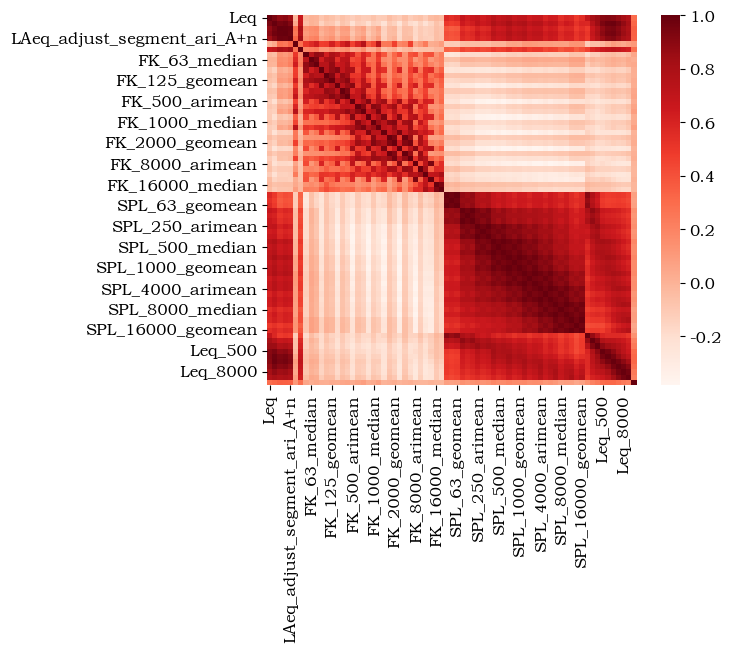

In [61]:
corr_matrix = X_ini.join(y).corr()
sns.heatmap(corr_matrix,annot = False,vmax = 1,square = True,cmap = "Reds")
plt.show()

In [66]:
corr_matrix["NIPTS"].sort_values(ascending=False).index

Index(['NIPTS', 'LAeq_adjust_total_ari_A+n', 'LAeq_adjust_total_geo_A+n',
       'LAeq_adjust_segment_ari_A+n', 'LAeq', 'Leq_2000', 'Leq_1000',
       'Leq_500', 'Leq', 'Leq_4000', 'max_Peak_SPL_dB', 'Leq_8000', 'Leq_250',
       'Leq_16000', 'Leq_125', 'SPL_1000_arimean', 'SPL_500_arimean',
       'SPL_2000_arimean', 'SPL_1000_geomean', 'SPL_500_geomean',
       'SPL_1000_median', 'SPL_2000_geomean', 'SPL_500_median',
       'SPL_4000_arimean', 'SPL_2000_median', 'SPL_250_arimean',
       'SPL_125_arimean', 'SPL_250_geomean', 'SPL_125_geomean',
       'SPL_4000_geomean', 'Leq_63', 'SPL_250_median', 'SPL_125_median',
       'SPL_4000_median', 'SPL_8000_arimean', 'kurtosis_geomean',
       'SPL_8000_geomean', 'SPL_16000_arimean', 'FK_500_geomean',
       'SPL_63_arimean', 'SPL_63_geomean', 'SPL_8000_median',
       'FK_1000_geomean', 'SPL_16000_geomean', 'SPL_63_median',
       'FK_250_geomean', 'FK_500_median', 'FK_250_median', 'FK_63_arimean',
       'SPL_16000_median', 'FK_63_geomean

In [25]:
corr_matrix["NIPTS"].abs().describe()

count    71.000000
mean      0.133579
std       0.145214
min       0.001172
25%       0.030190
50%       0.109658
75%       0.173193
max       1.000000
Name: NIPTS, dtype: float64

In [26]:
pearson_filter_features = seq(
    corr_matrix[np.abs(corr_matrix["NIPTS"]) > 0.1].index).filter(
        lambda x: not x.startswith("NIPTS")).list()
len(pearson_filter_features)

35

### Distance correction coefficient

* Select features whose distance correction coefficient with NIPTS value is larger than 0.02 (average value)

In [67]:
dcors = {}
for col in X_ini.columns:
    dcors[col] = dcov_all(X_ini[col].values, y.values)
pd.Series(dcors).describe()

count    70.000000
mean      0.024994
std       0.031147
min       0.001444
25%       0.006025
50%       0.010290
75%       0.026766
max       0.117312
dtype: float64

In [69]:
pd.Series(dcors).sort_values(ascending=False).index

Index(['LAeq_adjust_total_ari_A+n', 'LAeq_adjust_total_geo_A+n',
       'LAeq_adjust_segment_ari_A+n', 'LAeq', 'Leq_1000', 'Leq_2000',
       'Leq_500', 'Leq', 'max_Peak_SPL_dB', 'Leq_4000', 'Leq_250', 'Leq_8000',
       'Leq_125', 'Leq_16000', 'SPL_1000_arimean', 'SPL_500_arimean',
       'SPL_2000_arimean', 'SPL_1000_median', 'SPL_1000_geomean',
       'SPL_500_geomean', 'SPL_500_median', 'SPL_2000_geomean',
       'SPL_2000_median', 'SPL_250_arimean', 'SPL_4000_arimean',
       'SPL_125_arimean', 'SPL_250_geomean', 'Leq_63', 'SPL_125_geomean',
       'SPL_250_median', 'SPL_4000_geomean', 'SPL_125_median',
       'kurtosis_geomean', 'SPL_4000_median', 'FK_63_arimean',
       'SPL_8000_arimean', 'FK_500_median', 'FK_500_geomean',
       'FK_1000_geomean', 'FK_250_median', 'FK_1000_arimean', 'FK_500_arimean',
       'FK_1000_median', 'FK_250_geomean', 'SPL_63_arimean',
       'SPL_16000_arimean', 'SPL_8000_geomean', 'FK_125_arimean',
       'SPL_63_geomean', 'FK_250_arimean', 'FK_2000_

In [28]:
cdors_filter_features = seq(
    dcors.items()).filter(lambda x: x[1] > 0.02).map(lambda x: x[0]).list()
len(cdors_filter_features)

24

### Final filter

* Select features both in pearson filter and distance filter

In [29]:
final_filter_features = set(pearson_filter_features) & set(cdors_filter_features)
len(final_filter_features)

24

In [30]:
X_filter = X_ini[list(final_filter_features)].copy()
X_filter.shape

(2777, 24)

In [32]:
X_filter.columns

Index(['LAeq_adjust_total_ari_A+n', 'SPL_500_geomean', 'SPL_500_arimean',
       'LAeq_adjust_total_geo_A+n', 'Leq_8000', 'Leq_4000', 'SPL_500_median',
       'SPL_2000_arimean', 'Leq_500', 'SPL_2000_geomean', 'max_Peak_SPL_dB',
       'Leq_1000', 'Leq', 'SPL_250_arimean', 'SPL_1000_arimean',
       'SPL_2000_median', 'Leq_125', 'Leq_250', 'SPL_1000_geomean', 'Leq_2000',
       'Leq_16000', 'LAeq_adjust_segment_ari_A+n', 'SPL_1000_median', 'LAeq'],
      dtype='object')

## Feature Wrapper

* Wrapper will left half of the features.

In [33]:
wrapper = RFE(estimator=RandomForestRegressor(), n_features_to_select=X_filter.shape[1]//2)
wrapper = wrapper.fit(X_filter, y)
final_wrapper_features = X_filter.columns[wrapper.support_]

In [34]:
final_wrapper_features

Index(['LAeq_adjust_total_ari_A+n', 'LAeq_adjust_total_geo_A+n',
       'SPL_500_median', 'SPL_2000_geomean', 'max_Peak_SPL_dB', 'Leq_1000',
       'SPL_250_arimean', 'SPL_2000_median', 'Leq_125', 'Leq_2000',
       'Leq_16000', 'LAeq_adjust_segment_ari_A+n'],
      dtype='object')

In [35]:
X_wrapper = X_ini[final_wrapper_features].copy()
X_wrapper.shape

(2777, 12)

## Feature combination

* combination features with degree=2

In [36]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_combination = pd.DataFrame(poly.fit_transform(X_wrapper), columns=poly.get_feature_names_out(), index=X_wrapper.index)
X_combination.shape

(2777, 90)

#### Feature selection again
##### Feature filter

In [37]:
corr_matrix = X_combination.join(y).corr()
corr_matrix["NIPTS"].abs().describe()

count    91.000000
mean      0.270036
std       0.100563
min       0.147922
25%       0.213243
50%       0.267748
75%       0.324165
max       1.000000
Name: NIPTS, dtype: float64

In [39]:
sub_pearson_filter_features = seq(
    corr_matrix[np.abs(corr_matrix["NIPTS"]) > 0.25].index).filter(
        lambda x: not x.startswith("NIPTS")).list()
len(sub_pearson_filter_features)

55

In [40]:
dcors = {}
for col in X_combination.columns:
    dcors[col] = dcov_all(X_combination[col].values, y.values)
pd.Series(dcors).describe()

count    90.000000
mean      0.066948
std       0.032147
min       0.020429
25%       0.038338
50%       0.063974
75%       0.096893
max       0.119855
dtype: float64

In [42]:
sub_cdors_filter_features = seq(
    dcors.items()).filter(lambda x: x[1] > 0.06).map(lambda x: x[0]).list()
len(sub_cdors_filter_features)

49

In [43]:
sub_final_filter_features = set(sub_pearson_filter_features) & set(sub_cdors_filter_features)
len(sub_final_filter_features)

49

In [44]:
sub_final_filter_features

{'LAeq_adjust_segment_ari_A+n',
 'LAeq_adjust_segment_ari_A+n^2',
 'LAeq_adjust_total_ari_A+n',
 'LAeq_adjust_total_ari_A+n LAeq_adjust_segment_ari_A+n',
 'LAeq_adjust_total_ari_A+n LAeq_adjust_total_geo_A+n',
 'LAeq_adjust_total_ari_A+n Leq_1000',
 'LAeq_adjust_total_ari_A+n Leq_125',
 'LAeq_adjust_total_ari_A+n Leq_16000',
 'LAeq_adjust_total_ari_A+n Leq_2000',
 'LAeq_adjust_total_ari_A+n SPL_2000_geomean',
 'LAeq_adjust_total_ari_A+n SPL_250_arimean',
 'LAeq_adjust_total_ari_A+n SPL_500_median',
 'LAeq_adjust_total_ari_A+n max_Peak_SPL_dB',
 'LAeq_adjust_total_ari_A+n^2',
 'LAeq_adjust_total_geo_A+n',
 'LAeq_adjust_total_geo_A+n LAeq_adjust_segment_ari_A+n',
 'LAeq_adjust_total_geo_A+n Leq_1000',
 'LAeq_adjust_total_geo_A+n Leq_125',
 'LAeq_adjust_total_geo_A+n Leq_16000',
 'LAeq_adjust_total_geo_A+n Leq_2000',
 'LAeq_adjust_total_geo_A+n SPL_2000_geomean',
 'LAeq_adjust_total_geo_A+n SPL_250_arimean',
 'LAeq_adjust_total_geo_A+n SPL_500_median',
 'LAeq_adjust_total_geo_A+n max_Peak

In [45]:
X_combination_filter = X_combination[list(sub_final_filter_features)].copy()
X_combination_filter.shape

(2777, 49)

##### Feature wrapper

In [46]:
subwrapper = RFE(estimator=RandomForestRegressor(), n_features_to_select=X_combination_filter.shape[1]//2)
subwrapper = subwrapper.fit(X_combination_filter, y)
sub_final_wrapper_features = X_combination_filter.columns[subwrapper.support_]

In [47]:
sub_final_wrapper_features

Index(['LAeq_adjust_total_ari_A+n',
       'LAeq_adjust_total_ari_A+n max_Peak_SPL_dB',
       'LAeq_adjust_total_ari_A+n LAeq_adjust_segment_ari_A+n',
       'LAeq_adjust_total_geo_A+n', 'Leq_1000 Leq_16000',
       'Leq_1000 LAeq_adjust_segment_ari_A+n',
       'LAeq_adjust_total_ari_A+n SPL_2000_geomean',
       'LAeq_adjust_segment_ari_A+n^2', 'max_Peak_SPL_dB Leq_125',
       'Leq_2000^2', 'max_Peak_SPL_dB', 'Leq_1000', 'Leq_125 Leq_2000',
       'SPL_250_arimean LAeq_adjust_segment_ari_A+n',
       'LAeq_adjust_total_geo_A+n max_Peak_SPL_dB',
       'SPL_500_median LAeq_adjust_segment_ari_A+n', 'SPL_500_median Leq_2000',
       'Leq_1000 SPL_250_arimean', 'max_Peak_SPL_dB Leq_2000',
       'LAeq_adjust_total_geo_A+n LAeq_adjust_segment_ari_A+n',
       'max_Peak_SPL_dB Leq_1000', 'Leq_125 LAeq_adjust_segment_ari_A+n',
       'LAeq_adjust_total_geo_A+n SPL_2000_geomean',
       'Leq_16000 LAeq_adjust_segment_ari_A+n'],
      dtype='object')

In [48]:
X_combination_wrapper = X_combination_filter[sub_final_wrapper_features].copy()
X_combination_wrapper.shape

(2777, 24)

### Feature importance ranking

In [51]:
data_pool = Pool(data=X_combination_wrapper, label=y)
cv_params = {
    "learning_rate": 0.05,
    "l2_leaf_reg": 3,
    "max_depth": 10,
    "n_estimators": 15000,
    "early_stopping_rounds": 1000,
    "eval_metric": "RMSE",
    "metric_period": 50,
    "od_type": "Iter",
    "loss_function": "RMSE",
    "verbose": 1000,
    "random_seed": 42,
    "task_type": "CPU"
}
cv_data, cv_model = cv(
    data_pool,
    cv_params,
    plot=True,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 18.5286245	test: 18.6280706	best: 18.6280706 (0)	total: 34.5ms	remaining: 8m 36s
1000:	learn: 3.2000033	test: 12.6917182	best: 12.0710698 (97)	total: 35.6s	remaining: 8m 17s

bestTest = 12.07106977
bestIteration = 97

Training on fold [1/3]
0:	learn: 18.3662105	test: 18.9401098	best: 18.9401098 (0)	total: 43.7ms	remaining: 10m 55s
1000:	learn: 2.9640168	test: 13.1174156	best: 12.8925340 (176)	total: 35.6s	remaining: 8m 17s

bestTest = 12.89253397
bestIteration = 176

Training on fold [2/3]
0:	learn: 18.7639798	test: 18.1011286	best: 18.1011286 (0)	total: 48.9ms	remaining: 12m 12s
1000:	learn: 3.2131457	test: 12.3160990	best: 11.9304426 (88)	total: 35.5s	remaining: 8m 16s

bestTest = 11.93044256
bestIteration = 88



In [52]:
importances = dict(zip(X_combination_wrapper.columns, cv_model[2].get_feature_importance()))
seq(importances.items()).sorted(lambda x: x[1], reverse=True).dict()

{'max_Peak_SPL_dB Leq_125': 6.600275815692589,
 'LAeq_adjust_total_ari_A+n SPL_2000_geomean': 5.778002966509115,
 'Leq_1000 Leq_16000': 5.326652066111066,
 'Leq_2000^2': 5.319184189809835,
 'Leq_125 Leq_2000': 5.250384963401088,
 'max_Peak_SPL_dB': 5.1133105561538255,
 'Leq_16000 LAeq_adjust_segment_ari_A+n': 5.068203536366713,
 'SPL_500_median Leq_2000': 4.787711129182696,
 'SPL_500_median LAeq_adjust_segment_ari_A+n': 4.680500776180819,
 'Leq_1000': 4.611251577924188,
 'Leq_125 LAeq_adjust_segment_ari_A+n': 4.490591601560927,
 'SPL_250_arimean LAeq_adjust_segment_ari_A+n': 4.486992864327325,
 'LAeq_adjust_total_geo_A+n SPL_2000_geomean': 4.479187390517483,
 'Leq_1000 SPL_250_arimean': 4.0179624947273265,
 'LAeq_adjust_total_geo_A+n': 3.7624593654170617,
 'max_Peak_SPL_dB Leq_1000': 3.738425772393465,
 'LAeq_adjust_segment_ari_A+n^2': 3.591330039298841,
 'LAeq_adjust_total_geo_A+n max_Peak_SPL_dB': 3.113528045872451,
 'max_Peak_SPL_dB Leq_2000': 3.0638859583446365,
 'LAeq_adjust_total

In [55]:
model, MAE, importances_res = get_importance_from_regressor(
    X=X_combination_wrapper,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)

seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()

0:	learn: 13.1856307	total: 38.6ms	remaining: 6m 26s
1000:	learn: 3.4740804	total: 38.8s	remaining: 5m 48s
2000:	learn: 1.7103406	total: 1m 16s	remaining: 5m 5s
3000:	learn: 1.2672960	total: 1m 54s	remaining: 4m 27s
4000:	learn: 1.1595616	total: 2m 32s	remaining: 3m 48s
5000:	learn: 1.1350164	total: 3m 8s	remaining: 3m 8s
6000:	learn: 1.1296387	total: 3m 44s	remaining: 2m 29s
7000:	learn: 1.1282920	total: 4m 21s	remaining: 1m 52s
8000:	learn: 1.1279730	total: 4m 59s	remaining: 1m 14s
9000:	learn: 1.1278871	total: 5m 36s	remaining: 37.3s
9999:	learn: 1.1278669	total: 6m 13s	remaining: 0us


2024-01-10 14:50:42.898 | INFO     | ML_regression:get_importance_from_regressor:178 - ALL feature for model NIPTS: MAE = 9.8244


{'Leq_1000 Leq_16000': 5.680189355194448,
 'max_Peak_SPL_dB Leq_125': 5.582936254894653,
 'Leq_16000 LAeq_adjust_segment_ari_A+n': 5.503126842251084,
 'max_Peak_SPL_dB': 5.399644269374059,
 'Leq_1000': 5.245622069096669,
 'Leq_1000 SPL_250_arimean': 5.014654222713626,
 'SPL_250_arimean LAeq_adjust_segment_ari_A+n': 4.9369541451356165,
 'Leq_125 LAeq_adjust_segment_ari_A+n': 4.818696025263446,
 'SPL_500_median Leq_2000': 4.745398730547783,
 'LAeq_adjust_total_ari_A+n SPL_2000_geomean': 4.716795796820269,
 'SPL_500_median LAeq_adjust_segment_ari_A+n': 4.6699272947313935,
 'Leq_125 Leq_2000': 4.289521228732205,
 'LAeq_adjust_total_geo_A+n SPL_2000_geomean': 4.271858686822812,
 'max_Peak_SPL_dB Leq_1000': 4.170206013189878,
 'Leq_2000^2': 4.025040322867645,
 'LAeq_adjust_total_geo_A+n': 3.4107902463998694,
 'LAeq_adjust_total_ari_A+n max_Peak_SPL_dB': 3.393354651637076,
 'LAeq_adjust_total_ari_A+n': 3.3868840773160733,
 'max_Peak_SPL_dB Leq_2000': 3.2071494556692812,
 'LAeq_adjust_segment_

In [57]:
select_features = [
#  'Leq_1000 Leq_16000',
#  'max_Peak_SPL_dB Leq_125',
#  'Leq_16000 LAeq_adjust_segment_ari_A+n',
 'max_Peak_SPL_dB',
#  'Leq_1000',
#  'Leq_1000 SPL_250_arimean',
#  'SPL_250_arimean LAeq_adjust_segment_ari_A+n',
#  'Leq_125 LAeq_adjust_segment_ari_A+n',
#  'SPL_500_median Leq_2000',
#  'LAeq_adjust_total_ari_A+n SPL_2000_geomean',
#  'SPL_500_median LAeq_adjust_segment_ari_A+n',
#  'Leq_125 Leq_2000',
#  'LAeq_adjust_total_geo_A+n SPL_2000_geomean',
#  'max_Peak_SPL_dB Leq_1000',
#  'Leq_2000^2',
 'LAeq_adjust_total_geo_A+n',
 'LAeq_adjust_total_ari_A+n max_Peak_SPL_dB',
 'LAeq_adjust_total_ari_A+n',
#  'max_Peak_SPL_dB Leq_2000',
#  'LAeq_adjust_segment_ari_A+n^2',
#  'Leq_1000 LAeq_adjust_segment_ari_A+n',
#  'LAeq_adjust_total_ari_A+n LAeq_adjust_segment_ari_A+n',
 'LAeq_adjust_total_geo_A+n max_Peak_SPL_dB',
#  'LAeq_adjust_total_geo_A+n LAeq_adjust_segment_ari_A+n'
 ]
X_use = X_combination_wrapper if select_features == [] else X_combination_wrapper[select_features]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X_use,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)

0:	learn: 13.1921761	total: 15.1ms	remaining: 2m 30s
1000:	learn: 6.9888795	total: 11.3s	remaining: 1m 41s
2000:	learn: 4.5015174	total: 22.1s	remaining: 1m 28s
3000:	learn: 3.2227286	total: 33.1s	remaining: 1m 17s
4000:	learn: 2.4785781	total: 43.9s	remaining: 1m 5s
5000:	learn: 2.0605005	total: 54.8s	remaining: 54.8s
6000:	learn: 1.8230278	total: 1m 5s	remaining: 43.8s
7000:	learn: 1.6893926	total: 1m 16s	remaining: 32.9s
8000:	learn: 1.6129592	total: 1m 27s	remaining: 21.9s
9000:	learn: 1.5734094	total: 1m 38s	remaining: 11s
9999:	learn: 1.5484037	total: 1m 49s	remaining: 0us


2024-01-10 15:02:43.175 | INFO     | ML_regression:get_importance_from_regressor:178 - ALL feature for model NIPTS: MAE = 10.6864
